# BTC 💰📈 15-min Time Frame analysis

The purpose of this notebook is to analyse Bitcoin's price in a 15-minute time frame and it consists of two parts. Part one analyses the price change within the past year when the RSI indicator drops below 80 or crosses above 30. It consists of the following:

1) Read data, EDA and data preprocessing 

2) Calculating RSI

3) Identifying Bitcoin's up and down trends

4) Analysing the start and end date, price changes, percentage changes and number of candles in each trend

Part two predicts the price drop change and percentage and also number of candles when the RSI drops below 80 and it makes predictions on trained models.
1) Model 1 based on Facebook's Prophet

2) Model 2 based on neural networks

3) Model 3 based on Polynomial-Regression

## Part 1 

### Import libraries and Read Data

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np 
import pandas as pd
import pandas_ta as pta
from datetime import datetime

from fbprophet import Prophet

from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression

import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense

In [2]:
# Read the dataset with pandas

dataset = pd.read_csv('BTC.csv')
print('Datasets shape:', dataset.shape)

Datasets shape: (350688, 2)


In [3]:
dataset.head(7)

,close,timestamp
0,4.58,1325376000
1,4.58,1325376900
2,4.58,1325377800
3,4.58,1325378700
4,4.58,1325379600
5,4.58,1325380500
6,4.58,1325381400


In [4]:
dataset.tail(7)

,close,timestamp
350681,46434.81,1640988900
350682,46396.86,1640989800
350683,46290.58,1640990700
350684,46303.98,1640991600
350685,46429.65,1640992500
350686,46350.44,1640993400
350687,46465.54,1640994300


### EDA and Data Preprocessing

In [5]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350688 entries, 0 to 350687
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   close      350688 non-null  float64
 1   timestamp  350688 non-null  int64  
dtypes: float64(1), int64(1)
memory usage: 5.4 MB


In [6]:
dataset.isnull().sum()

close        0
timestamp    0
dtype: int64

In [7]:
dataset.describe().T

,count,mean,std,min,25%,50%,75%,max
close,350688.0,7.884545e+03,1.418994e+04,4.140000e+00,2.704975e+02,9.124200e+02,8.605285e+03,6.871889e+04
timestamp,350688.0,1.483185e+09,9.111154e+07,1.325376e+09,1.404281e+09,1.483185e+09,1.562090e+09,1.640994e+09


In [8]:
# Convert unix time to human readable format 

start_date = datetime.fromtimestamp(dataset['timestamp'].iloc[0]).strftime("%b %d %Y %H:%M:%S")
end_date = datetime.fromtimestamp(dataset['timestamp'].iloc[-1]).strftime("%b %d %Y %H:%M:%S")

print('Start Date: ', start_date)
print('End Date: ', end_date)

Start Date:  Jan 01 2012 03:30:00
End Date:  Jan 01 2022 03:15:00


In [9]:
df = dataset.copy()
df.head(3)

,close,timestamp
0,4.58,1325376000
1,4.58,1325376900
2,4.58,1325377800


In [10]:
df['time'] = ''
times = []

for time in df['timestamp']:
    times.append(datetime.fromtimestamp(time).strftime("%b %d %Y %H:%M:%S"))

df['time'] = times
df.head(3)

,close,timestamp,time
0,4.58,1325376000,Jan 01 2012 03:30:00
1,4.58,1325376900,Jan 01 2012 03:45:00
2,4.58,1325377800,Jan 01 2012 04:00:00


In [11]:
del df['timestamp']
df.head(3)

,close,time
0,4.58,Jan 01 2012 03:30:00
1,4.58,Jan 01 2012 03:45:00
2,4.58,Jan 01 2012 04:00:00


In [12]:
# Select last year's data 

df = df.tail(35040)       
df = df.reset_index()   
df.head(3)

,index,close,time
0,315648,28985.51125,Jan 01 2021 03:30:00
1,315649,28773.91875,Jan 01 2021 03:45:00
2,315650,28856.53125,Jan 01 2021 04:00:00


In [13]:
del df['index']
df.head(3)

,close,time
0,28985.51125,Jan 01 2021 03:30:00
1,28773.91875,Jan 01 2021 03:45:00
2,28856.53125,Jan 01 2021 04:00:00


In [14]:
start_date = df['time'].iloc[0]
end_date = df['time'].iloc[-1]

print('Datasets shape:', df.shape)
print('Start Date: ', start_date)
print('End Date: ', end_date)

Datasets shape: (35040, 2)
Start Date:  Jan 01 2021 03:30:00
End Date:  Jan 01 2022 03:15:00


### Calculate RSI 

The Relative Strength Index (RSI), is a momentum oscillator that measures the speed and change of price movements. The RSI oscillates between zero and 100. Traditionally the RSI is considered overbought when above 70 and oversold when below 30.

In this section RSI is implemented in two ways. The first function is written using the "pandas_ta" library and the second function is written by myself.

In this notebook the first function has been used while the second function can also be used.

#### Calculate RSI using pandas_ta

In [15]:
def calculate_rsi(close_price, time_period=14):
    rsi = list(pta.rsi(close_price, time_period))
    return rsi

df['rsi'] = ''
rsi = calculate_rsi(df['close'], 14)
df['rsi'] = rsi

print('5 RSI samples: ', rsi[15:20])
df.tail(3)

5 RSI samples:  [59.836025448315866, 60.07459367805899, 60.644715691853136, 63.26140621186176, 50.40241955208979]


,close,time,rsi
35037,46429.65,Jan 01 2022 02:45:00,45.825678
35038,46350.44,Jan 01 2022 03:00:00,43.648455
35039,46465.54,Jan 01 2022 03:15:00,47.548184


#### Calculate RSI function

In [16]:
rsi_df = df.copy()
del rsi_df['time']
del rsi_df['rsi']

rsi_df.head(3)

,close
0,28985.51125
1,28773.91875
2,28856.53125


In [17]:
def rsi(close_price, time_period = 14):
    
    # Calculate price differences
    close_price['diff'] = close_price.diff(1)
    
    # Calculate avg. gains/losses
    close_price['gain'] = close_price['diff'].clip(lower=0)
    close_price['loss'] = close_price['diff'].clip(upper=0).abs()
    close_price['avg_gain'] = close_price['gain'].rolling(window=time_period, min_periods=time_period).mean()[:time_period+1]
    close_price['avg_loss'] = close_price['loss'].rolling(window=time_period, min_periods=time_period).mean()[:time_period+1]
    
    # Average gains
    for i, row in enumerate(close_price['avg_gain'].iloc[time_period+1:]):
        close_price['avg_gain'].iloc[i + time_period + 1] =\
        (close_price['avg_gain'].iloc[i + time_period] * (time_period - 1) + close_price['gain'].iloc[i + time_period + 1]) / time_period
    
    # Average losses
    for i, row in enumerate(close_price['avg_loss'].iloc[time_period+1:]):
        close_price['avg_loss'].iloc[i + time_period + 1] =\
        (close_price['avg_loss'].iloc[i + time_period] * (time_period - 1) + close_price['loss'].iloc[i + time_period + 1]) / time_period
    
    # Calculate RS values
    close_price['rs'] = close_price['avg_gain'] / close_price['avg_loss']

    # Calculate RSI
    close_price['rsi'] = 100 - (100 / (1.0 + rsi_df['rs']))
    
    return close_price

rsi = rsi(rsi_df, time_period = 14)
rsi

,close,diff,gain,loss,avg_gain,avg_loss,rs,rsi
0,28985.51125,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,28773.91875,-211.5925,0.0000,211.5925,NaN,NaN,NaN,NaN
2,28856.53125,82.6125,82.6125,0.0000,NaN,NaN,NaN,NaN
3,28960.97375,104.4425,104.4425,0.0000,NaN,NaN,NaN,NaN
4,29026.08625,65.1125,65.1125,0.0000,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
35035,46290.58000,-106.2800,0.0000,106.2800,53.479055,76.747722,0.696816,41.066097
35036,46303.98000,13.4000,13.4000,0.0000,50.616265,71.265742,0.710247,41.528907
35037,46429.65000,125.6700,125.6700,0.0000,55.977247,66.175331,0.845893,45.825678
35038,46350.44000,-79.2100,0.0000,79.2100,51.978872,67.106379,0.774574,43.648455


### Calculate Break 80

This function checks all the points within the past year's RSI and returns the points that drop below 80.

In [18]:
df['break_80'] = 0
df.tail(3)

,close,time,rsi,break_80
35037,46429.65,Jan 01 2022 02:45:00,45.825678,0
35038,46350.44,Jan 01 2022 03:00:00,43.648455,0
35039,46465.54,Jan 01 2022 03:15:00,47.548184,0


In [19]:
def calculate_break_80(dataframe):
    for index in range(len(dataframe) - 1):
        first = dataframe['rsi'][index]
        second = dataframe['rsi'][index + 1]
    
        if first >= 80 and second < 80:
            dataframe['break_80'][index + 1] = 1
    return dataframe

break_80 = calculate_break_80(df)
df.head(3)

,close,time,rsi,break_80
0,28985.51125,Jan 01 2021 03:30:00,NaN,0
1,28773.91875,Jan 01 2021 03:45:00,NaN,0
2,28856.53125,Jan 01 2021 04:00:00,NaN,0


In [20]:
df['break_80'].value_counts()

0    34963
1       77
Name: break_80, dtype: int64

### Calculate Break 30

This function checks all the points within the past year's RSI and returns the points across 30.

In [21]:
df['break_30'] = 0
df.tail(3)

,close,time,rsi,break_80,break_30
35037,46429.65,Jan 01 2022 02:45:00,45.825678,0,0
35038,46350.44,Jan 01 2022 03:00:00,43.648455,0,0
35039,46465.54,Jan 01 2022 03:15:00,47.548184,0,0


In [22]:
def calculate_break_30(dataframe):
    for index in range(len(df) - 1):
        first = dataframe['rsi'][index]
        second = dataframe['rsi'][index + 1]
    
        if first <= 30 and second > 30:
            dataframe['break_30'][index + 1] = 1
    return dataframe

break_30 = calculate_break_30(df)
df.head(3)

,close,time,rsi,break_80,break_30
0,28985.51125,Jan 01 2021 03:30:00,NaN,0,0
1,28773.91875,Jan 01 2021 03:45:00,NaN,0,0
2,28856.53125,Jan 01 2021 04:00:00,NaN,0,0


In [23]:
df['break_30'].value_counts()

0    34549
1      491
Name: break_30, dtype: int64

### Downtrends

This function uses break 80 points to identify all downtrends within the past year's data. It returns start and end dates, number of candles, price variation and It's percentage for each of those downtrends.

In [24]:
downtrends = pd.DataFrame(columns=['start_date', 'end_date', 'number_of_candles', 'price_change', 'percentage'])
downtrends

,start_date,end_date,number_of_candles,price_change,percentage


In [25]:
def calculate_downtrends(input_dataframe, res_dataframe):
    # Fill start date
    for item in input_dataframe['break_80']:
        if item == 1:
            index = input_dataframe[input_dataframe['break_80'] == item].index.values
            res_dataframe['start_date'] = input_dataframe['time'][index]
            
            
    for date in res_dataframe['start_date']:
        res_dataframe_index = int(res_dataframe[res_dataframe['start_date'] == date].index.values)
        input_dataframe_index = int(input_dataframe[input_dataframe['time'] == date].index.values)
        rsi = input_dataframe['rsi'][input_dataframe_index]  
        i = 1
        first = rsi
        second = input_dataframe['rsi'][input_dataframe_index + i]

        if first <= second: 
            # The downtrend did not continue
            res_dataframe['end_date'][res_dataframe_index] = date
            res_dataframe['number_of_candles'][res_dataframe_index] = 0
            res_dataframe['price_change'][res_dataframe_index] = 0
            res_dataframe['percentage'][res_dataframe_index] = 0

        else:
            number_of_candles = 0
            # The downtrend continued
            while first > second:
                first = second
                i += 1
                number_of_candles += 1
                second = input_dataframe['rsi'][input_dataframe_index + i]
                index = int(input_dataframe[input_dataframe['rsi'] == first].index.values)

                res_dataframe['end_date'][res_dataframe_index] = input_dataframe['time'][index]
                res_dataframe['number_of_candles'][res_dataframe_index] = number_of_candles
                res_dataframe['price_change'][res_dataframe_index] = input_dataframe['close'][index] - \
                        input_dataframe['close'][input_dataframe_index]
                res_dataframe['percentage'][res_dataframe_index] = ((input_dataframe['close'][index] - \
                        input_dataframe['close'][input_dataframe_index]) / df['close'][input_dataframe_index]) * 100 

    return res_dataframe 

calculate_downtrends(df, downtrends)

,start_date,end_date,number_of_candles,price_change,percentage
148,Jan 02 2021 16:30:00,Jan 02 2021 16:30:00,0,0,0
153,Jan 02 2021 17:45:00,Jan 02 2021 18:00:00,1,-263.77571,-0.840612
169,Jan 02 2021 21:45:00,Jan 02 2021 21:45:00,0,0,0
224,Jan 03 2021 11:30:00,Jan 03 2021 11:45:00,1,-374.26715,-1.085615
650,Jan 07 2021 22:00:00,Jan 07 2021 22:15:00,1,-1300.3925,-3.324882
...,...,...,...,...,...
30531,Nov 15 2021 04:15:00,Nov 15 2021 04:15:00,0,0,0
31866,Nov 29 2021 02:00:00,Nov 29 2021 02:30:00,2,-286.07,-0.507974
31875,Nov 29 2021 04:15:00,Nov 29 2021 04:15:00,0,0,0
34006,Dec 21 2021 09:00:00,Dec 21 2021 09:15:00,1,-219.58,-0.452278


### Uptrends

This function uses break 30 points to identify all uptrends within the past year's data. It returns start and end dates, number of candles, price variation and It's percentage for each of those uptrends.

In [26]:
uptrends = pd.DataFrame(columns=['start_date', 'end_date', 'number_of_candles', 'price_change', 'percentage'])
uptrends

,start_date,end_date,number_of_candles,price_change,percentage


In [27]:
def calculate_uptrends(input_dataframe, res_dataframe):
    for item in input_dataframe['break_30']:
        if item == 1:
            index = input_dataframe[input_dataframe['break_30'] == item].index.values
            res_dataframe['start_date'] = input_dataframe['time'][index]
            
            
    for date in res_dataframe['start_date']:
        res_dataframe_index = int(res_dataframe[res_dataframe['start_date'] == date].index.values)
        input_dataframe_index = int(input_dataframe[input_dataframe['time'] == date].index.values)
        rsi = input_dataframe['rsi'][input_dataframe_index]
        i = 1
        first = rsi
        second = input_dataframe['rsi'][input_dataframe_index + i]
        
        if first >= second: 
            # The uptrend did not continue
            res_dataframe['end_date'][res_dataframe_index] = date
            res_dataframe['number_of_candles'][res_dataframe_index] = 0
            res_dataframe['price_change'][res_dataframe_index] = 0
            res_dataframe['percentage'][res_dataframe_index] = 0

        else:
            number_of_candles = 0
            # The uptrend did not continued
            while first < second:
                first = second
                i += 1
                number_of_candles += 1
                second = input_dataframe['rsi'][input_dataframe_index + i]
                index = int(input_dataframe[input_dataframe['rsi'] == first].index.values)

            res_dataframe['end_date'][res_dataframe_index] = input_dataframe['time'][index]
            res_dataframe['number_of_candles'][res_dataframe_index] = number_of_candles
            res_dataframe['price_change'][res_dataframe_index] = input_dataframe['close'][index] - input_dataframe['close'][input_dataframe_index]
            res_dataframe['percentage'][res_dataframe_index] = ((input_dataframe['close'][index] - \
                        input_dataframe['close'][input_dataframe_index]) / input_dataframe['close'][input_dataframe_index]) * 100 
        
    return res_dataframe

calculate_uptrends(df, uptrends)

,start_date,end_date,number_of_candles,price_change,percentage
181,Jan 03 2021 00:45:00,Jan 03 2021 01:00:00,1,133.89143,0.425055
332,Jan 04 2021 14:30:00,Jan 04 2021 14:30:00,0,0,0
684,Jan 08 2021 06:30:00,Jan 08 2021 07:00:00,2,1052.17,2.828732
913,Jan 10 2021 15:45:00,Jan 10 2021 16:00:00,1,136.18036,0.344517
936,Jan 10 2021 21:30:00,Jan 10 2021 21:30:00,0,0,0
...,...,...,...,...,...
34805,Dec 29 2021 16:45:00,Dec 29 2021 16:45:00,0,0,0
34807,Dec 29 2021 17:15:00,Dec 29 2021 17:30:00,1,500.17,1.066404
34848,Dec 30 2021 03:30:00,Dec 30 2021 03:30:00,0,0,0
34850,Dec 30 2021 04:00:00,Dec 30 2021 04:30:00,2,194.09,0.417407


## Part 2

### Model 1 - Prophet

In order to train and implement the first model, Facebook's Prophet has been used.

This model has been trained on all data and is used to predict future data. Then the predicted output is fed to the downtrend function in order to predict the number of candles and the percentage of falling prices.

In [28]:
prophet_df = dataset.copy()
prophet_df = prophet_df.tail(35040)
prophet_df.head(3)

,close,timestamp
315648,28985.51125,1609459200
315649,28773.91875,1609460100
315650,28856.53125,1609461000


In [29]:
prophet_df['time'] = ''
times = []

for time in prophet_df['timestamp']:
    times.append(datetime.fromtimestamp(time).strftime("%b %d %Y %H:%M:%S"))
    
prophet_df['time'] = times
prophet_df['time']= pd.to_datetime(prophet_df['time'])


del prophet_df['timestamp']

prophet_df = prophet_df.reset_index()
del prophet_df['index']

prophet_df.columns = ['y', 'ds']
prophet_df.head(3)

,y,ds
0,28985.51125,2021-01-01 03:30:00
1,28773.91875,2021-01-01 03:45:00
2,28856.53125,2021-01-01 04:00:00


In [30]:
prophet_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35040 entries, 0 to 35039
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   y       35040 non-null  float64       
 1   ds      35040 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(1)
memory usage: 547.6 KB


In [31]:
prophet_model = Prophet(yearly_seasonality=True)   
prophet_model.fit(prophet_df)

Initial log joint probability = -683.957


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        105889    0.00308206       859.454      0.1441           1      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        106153     0.0322656       3425.63           1           1      241   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299        107154      0.085174       1276.34           1           1      363   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399        107541    0.00566746       29803.4    0.007662           1      479   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499        107600    0.00228042       1031.79           1           1      590   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     599     

In [32]:
future_dataframe = prophet_model.make_future_dataframe(periods=300, freq='15min')
forecast = prophet_model.predict(future_dataframe)
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
35331,2022-01-04 05:15:00,-111351.189912,41394.557203,46039.588647,-111351.189912,-111343.913195,155073.194289,155073.194289,155073.194289,45.620912,...,30.509609,30.509609,30.509609,154997.063768,154997.063768,154997.063768,0.0,0.0,0.0,43722.004377
35332,2022-01-04 05:30:00,-111380.717162,41348.681979,46162.855377,-111380.717162,-111373.392150,155080.390377,155080.390377,155080.390377,42.775659,...,26.862542,26.862542,26.862542,155010.752176,155010.752176,155010.752176,0.0,0.0,0.0,43699.673215
35333,2022-01-04 05:45:00,-111410.244412,41408.642437,46186.587777,-111410.244412,-111399.241064,155086.003836,155086.003836,155086.003836,38.414411,...,23.175422,23.175422,23.175422,155024.414003,155024.414003,155024.414003,0.0,0.0,0.0,43675.759424
35334,2022-01-04 06:00:00,-111439.771662,41372.791575,46002.024059,-111439.771662,-111428.154911,155090.150154,155090.150154,155090.150154,32.650347,...,19.450571,19.450571,19.450571,155038.049236,155038.049236,155038.049236,0.0,0.0,0.0,43650.378492
35335,2022-01-04 06:15:00,-111469.298912,41172.442973,46077.262941,-111469.298912,-111457.357890,155093.016942,155093.016942,155093.016942,25.668727,...,15.690350,15.690350,15.690350,155051.657865,155051.657865,155051.657865,0.0,0.0,0.0,43623.718030


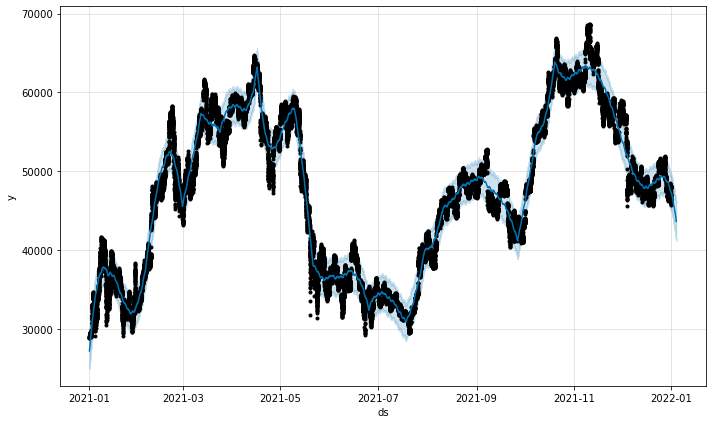

In [33]:
plot1 = prophet_model.plot(forecast)

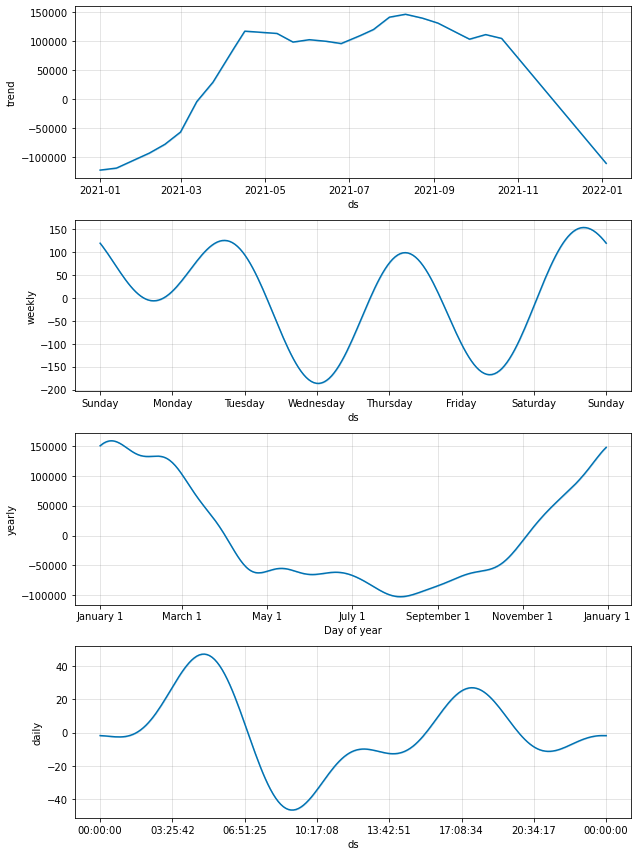

In [34]:
plot2 = prophet_model.plot_components(forecast)

In [35]:
forecast = forecast[['ds', 'yhat']]
forecast.head(3)

,ds,yhat
0,2021-01-01 03:30:00,27189.476847
1,2021-01-01 03:45:00,27215.559158
2,2021-01-01 04:00:00,27241.236945


In [36]:
rsi = calculate_rsi(forecast['yhat'], 14)
forecast['rsi'] = rsi
forecast.tail(3)

,ds,yhat,rsi
35333,2022-01-04 05:45:00,43675.759424,1.861350e-10
35334,2022-01-04 06:00:00,43650.378492,1.672256e-10
35335,2022-01-04 06:15:00,43623.718030,1.499890e-10


In [37]:
forecast['break_80'] = 0
break_80 = calculate_break_80(forecast)
forecast.tail(3)

,ds,yhat,rsi,break_80
35333,2022-01-04 05:45:00,43675.759424,1.861350e-10,0
35334,2022-01-04 06:00:00,43650.378492,1.672256e-10,0
35335,2022-01-04 06:15:00,43623.718030,1.499890e-10,0


In [38]:
forecast['break_80'].value_counts()

0    35135
1      201
Name: break_80, dtype: int64

In [39]:
res_df = pd.DataFrame(columns=['start_date', 'end_date', 'number_of_candles', 'price_change', 'percentage'])
res_df

,start_date,end_date,number_of_candles,price_change,percentage


In [40]:
forecast.columns = ['time', 'close', 'rsi', 'break_80']
calculate_downtrends(forecast, res_df)

,start_date,end_date,number_of_candles,price_change,percentage
685,2021-01-08 06:45:00,2021-01-08 08:15:00,6,-21.782126,-0.057314
785,2021-01-09 07:45:00,2021-01-09 08:15:00,2,-2.174975,-0.005442
830,2021-01-09 19:00:00,2021-01-09 21:45:00,11,-27.509902,-0.067797
968,2021-01-11 05:30:00,2021-01-11 09:15:00,15,-97.675105,-0.262257
1164,2021-01-13 06:30:00,2021-01-13 08:15:00,7,-26.628299,-0.080635
...,...,...,...,...,...
34378,2021-12-25 07:00:00,2021-12-25 08:30:00,6,-18.856463,-0.036925
34425,2021-12-25 18:45:00,2021-12-25 22:00:00,13,-36.10423,-0.071144
34566,2021-12-27 06:00:00,2021-12-27 09:00:00,12,-63.672273,-0.125728
34614,2021-12-27 18:00:00,2021-12-28 03:00:00,36,-127.918299,-0.249086


### Model 2 - NN

The second model is trained using a neural network by the concept of using "price changes" and "the number of candles" instead of "time" to predict future data. But since training neural network models requires a large amount of data, it is not fully applicable.

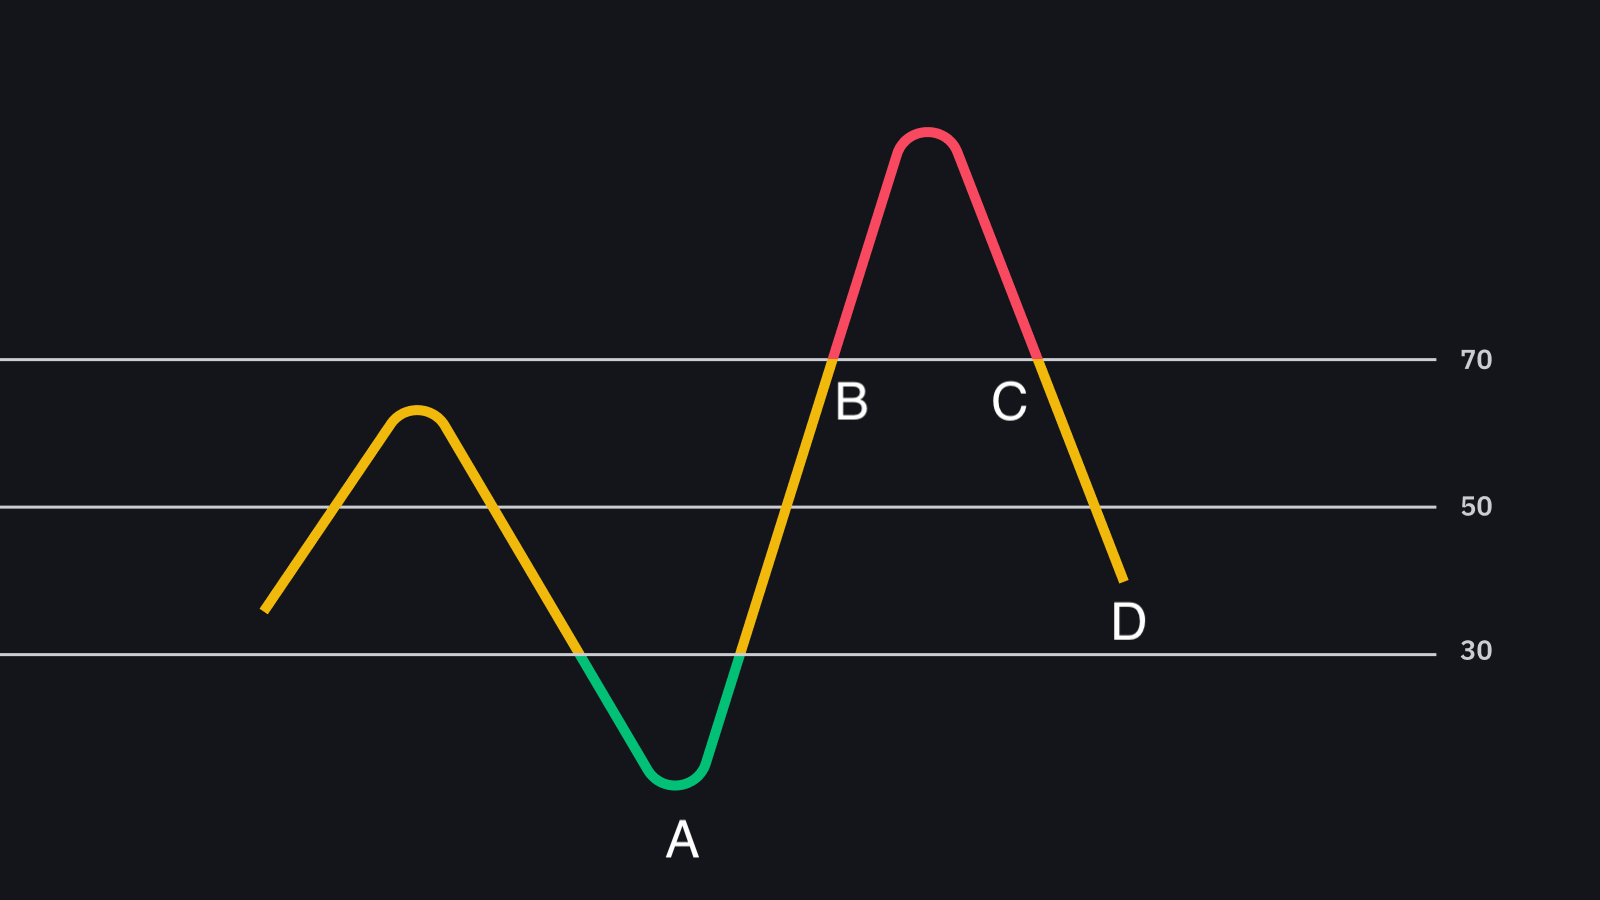

In [41]:
nn_df = df.copy()
del nn_df['break_30']
nn_df.head(3)

,close,time,rsi,break_80
0,28985.51125,Jan 01 2021 03:30:00,NaN,0
1,28773.91875,Jan 01 2021 03:45:00,NaN,0
2,28856.53125,Jan 01 2021 04:00:00,NaN,0


In [42]:
nn_df['break_80'].value_counts()

0    34963
1       77
Name: break_80, dtype: int64

##### from B to C

In [43]:
b_c = pd.DataFrame(columns=['start_date', 'end_date', 'number_of_candles', 'percentage'])

for item in nn_df['break_80']:
    if item == 1:
        index = nn_df[nn_df['break_80'] == item].index.values
        time = []
        for i in index:
            time.append(nn_df['time'][i])
        b_c['end_date'] = time
        break
        
b_c.head(3)                   

,start_date,end_date,number_of_candles,percentage
0,NaN,Jan 02 2021 16:30:00,NaN,NaN
1,NaN,Jan 02 2021 17:45:00,NaN,NaN
2,NaN,Jan 02 2021 21:45:00,NaN,NaN


In [44]:
candle = []
start_dates = []

for date in b_c['end_date']:
    nn_df_index = nn_df[nn_df['time'] == date].index.values
    candle_count = 0
    nn_df_index -= 1
    nn_df_rsi = list(nn_df['rsi'][nn_df_index])
    while nn_df_rsi[0] >= 80:
        candle_count += 1
        nn_df_index -= 1
        nn_df_rsi = list(nn_df['rsi'][nn_df_index])
        start_date = list(nn_df['time'][nn_df_index + 1])
        start_date = start_date[0]
    candle.append(candle_count)
    start_dates.append(start_date)
    
    
b_c['number_of_candles'] = candle
b_c['start_date'] = start_dates

b_c.head(3)    

,start_date,end_date,number_of_candles,percentage
0,Jan 02 2021 16:15:00,Jan 02 2021 16:30:00,1,NaN
1,Jan 02 2021 17:00:00,Jan 02 2021 17:45:00,3,NaN
2,Jan 02 2021 19:45:00,Jan 02 2021 21:45:00,8,NaN


In [45]:
start = list(b_c['start_date'])
end = list(b_c['end_date'])

price_changes = []
percentages = []

for i in range(len(start)):
    s = start[i]
    e = end[i]
    
    index_s = nn_df[nn_df['time'] == s].index.values
    index_e = nn_df[nn_df['time'] == e].index.values
    
    price_s = list(nn_df['close'][index_s])
    price_e = list(nn_df['close'][index_e])
    
    price_change = price_e[0] - price_s[0]
    price_changes.append(price_change)
    
    percentage = ((price_e[0] - price_s[0]) / price_s[0]) * 100
    percentages.append(percentage)
    
b_c['price_change'] = price_changes
b_c['percentage'] = percentages

b_c.head(3)      

,start_date,end_date,number_of_candles,percentage,price_change
0,Jan 02 2021 16:15:00,Jan 02 2021 16:30:00,1,-0.320269,-98.42285
1,Jan 02 2021 17:00:00,Jan 02 2021 17:45:00,3,1.622768,501.07714
2,Jan 02 2021 19:45:00,Jan 02 2021 21:45:00,8,1.730944,555.13821


##### from A to B

In [46]:
a_b = pd.DataFrame(columns=['start_date', 'end_date', 'number_of_candles', 'percentage'])
a_b.head(3)

,start_date,end_date,number_of_candles,percentage


In [47]:
end_date = list(b_c['start_date'])
a_b['end_date'] = end_date
a_b.head(3)

,start_date,end_date,number_of_candles,percentage
0,NaN,Jan 02 2021 16:15:00,NaN,NaN
1,NaN,Jan 02 2021 17:00:00,NaN,NaN
2,NaN,Jan 02 2021 19:45:00,NaN,NaN


In [48]:
candle = []
start_dates = []

for date in a_b['end_date']:
    nn_df_index = nn_df[nn_df['time'] == date].index.values
    candle_count = 0
    
    first = list(nn_df['rsi'][nn_df_index])
    nn_df_index -= 1
    second = list(nn_df['rsi'][nn_df_index])

    if first >= second:
        while first >= second:
            candle_count += 1
            nn_df_index -= 1
            first = second 
            second = list(nn_df['rsi'][nn_df_index])
            start_date = list(nn_df['time'][nn_df_index + 1])
            start_date = start_date[0]
        
        candle.append(candle_count)
        start_dates.append(start_date)
            
    else:
        pass
    
a_b['number_of_candles'] = candle
a_b['start_date'] = start_dates

a_b.head(3)

,start_date,end_date,number_of_candles,percentage
0,Jan 02 2021 15:00:00,Jan 02 2021 16:15:00,5,NaN
1,Jan 02 2021 16:30:00,Jan 02 2021 17:00:00,2,NaN
2,Jan 02 2021 18:45:00,Jan 02 2021 19:45:00,4,NaN


In [49]:
start = list(a_b['start_date'])
end = list(a_b['end_date'])
price_changes = []
percentages = []

for i in range(len(start)):
    s = start[i]
    e = end[i]
    
    index_s = nn_df[nn_df['time'] == s].index.values
    index_e = nn_df[nn_df['time'] == e].index.values
    
    price_s = list(nn_df['close'][index_s])
    price_e = list(nn_df['close'][index_e])
    
    price_change = price_e[0] - price_s[0]
    price_changes.append(price_change)
    
    percentage = ((price_e[0] - price_s[0]) / price_s[0]) * 100
    percentages.append(percentage)
    
a_b['price_change'] = price_changes
a_b['percentage'] = percentages

a_b.head(3)

,start_date,end_date,number_of_candles,percentage,price_change
0,Jan 02 2021 15:00:00,Jan 02 2021 16:15:00,5,3.472188,1031.24285
1,Jan 02 2021 16:30:00,Jan 02 2021 17:00:00,2,0.799854,245.01857
2,Jan 02 2021 18:45:00,Jan 02 2021 19:45:00,4,2.514342,786.60715


##### from C to D

In [50]:
c_d = pd.DataFrame(columns=['start_date', 'end_date', 'number_of_candles', 'price_change', 'percentage'])

for item in nn_df['break_80']:
    if item == 1:
        index = nn_df[nn_df['break_80'] == item].index.values
        c_d['start_date'] = nn_df['time'][index]
        
c_d.head(3)

,start_date,end_date,number_of_candles,price_change,percentage
148,Jan 02 2021 16:30:00,NaN,NaN,NaN,NaN
153,Jan 02 2021 17:45:00,NaN,NaN,NaN,NaN
169,Jan 02 2021 21:45:00,NaN,NaN,NaN,NaN


In [51]:
for date in c_d['start_date']:
    c_d_index = int(c_d[c_d['start_date'] == date].index.values)
    nn_df_index = int(nn_df[nn_df['time'] == date].index.values)
    rsi = nn_df['rsi'][nn_df_index]  
    i = 1
    first = rsi
    second = nn_df['rsi'][nn_df_index + i]

    if first <= second: 
        c_d['end_date'][c_d_index] = date
        c_d['number_of_candles'][c_d_index] = 0
        c_d['price_change'][c_d_index] = 0
        c_d['percentage'][c_d_index] = 0
        
    elif first > second:
        number_of_candles = 0
        while first > second:
            first = second
            i += 1
            number_of_candles += 1
            second = nn_df['rsi'][nn_df_index + i]
            index = int(nn_df[nn_df['rsi'] == first].index.values)
        
        c_d['end_date'][c_d_index] = nn_df['time'][index]
        c_d['number_of_candles'][c_d_index] = number_of_candles
        c_d['price_change'][c_d_index] = nn_df['close'][index] - nn_df['close'][nn_df_index]
        c_d['percentage'][c_d_index] = ((nn_df['close'][index] - nn_df['close'][nn_df_index]) / nn_df['close'][nn_df_index]) * 100 
        
c_d.head(3)

,start_date,end_date,number_of_candles,price_change,percentage
148,Jan 02 2021 16:30:00,Jan 02 2021 16:30:00,0,0,0
153,Jan 02 2021 17:45:00,Jan 02 2021 18:00:00,1,-263.77571,-0.840612
169,Jan 02 2021 21:45:00,Jan 02 2021 21:45:00,0,0,0


In [52]:
final_df = pd.DataFrame(columns=['input_candles', 'input_percetage','output_candles', 'output_percentage'])
final_df.head(3)

,input_candles,input_percetage,output_candles,output_percentage


In [53]:
a_b_candles = list(a_b['number_of_candles'])
b_c_candles = list(b_c['number_of_candles'])
candles = []

for (item1, item2) in zip(a_b_candles, b_c_candles):
    candles.append(item1 + item2)

final_df['input_candles'] = candles
final_df.head(3)

,input_candles,input_percetage,output_candles,output_percentage
0,6,NaN,NaN,NaN
1,5,NaN,NaN,NaN
2,12,NaN,NaN,NaN


In [54]:
c_d_candles = list(c_d['number_of_candles'])

final_df['output_candles'] = c_d_candles
final_df.head(3)

,input_candles,input_percetage,output_candles,output_percentage
0,6,NaN,0,NaN
1,5,NaN,1,NaN
2,12,NaN,0,NaN


In [55]:
start = list(a_b['start_date'])
end = list(b_c['end_date'])
start_index = []
end_index = []
start_price = []
end_price = []

for date in start:
    start_index.append(int(nn_df[nn_df['time'] == date].index.values))

for date in end:
    end_index.append(int(nn_df[nn_df['time'] == date].index.values))
    
for index in start_index:
    start_price.append(nn_df['close'][index])

for index in end_index:
    end_price.append(nn_df['close'][index])

input_percentage = []
for (item1, item2) in zip(start_price, end_price):
    input_percentage.append(((item2 - item1) / item1) * 100)


final_df['input_percetage'] = input_percentage
final_df.head(3)

,input_candles,input_percetage,output_candles,output_percentage
0,6,3.140799,0,NaN
1,5,2.435602,1,NaN
2,12,4.288808,0,NaN


In [56]:
c_d_percentage = list(c_d['percentage'])
final_df['output_percentage'] = c_d_percentage
final_df.head(3)

,input_candles,input_percetage,output_candles,output_percentage
0,6,3.140799,0,0.000000
1,5,2.435602,1,-0.840612
2,12,4.288808,0,0.000000


##### Model for output candles

In [57]:
final_df.head()

,input_candles,input_percetage,output_candles,output_percentage
0,6,3.140799,0,0.000000
1,5,2.435602,1,-0.840612
2,12,4.288808,0,0.000000
3,4,1.483208,1,-1.085615
4,3,-1.406409,1,-3.324882


In [58]:
X = final_df[['input_candles', 'input_percetage']]
y = final_df['output_candles']

X = X.to_numpy().astype('float32')
y = y.to_numpy().astype('float32').reshape(-1, 1)

print('X :', X[:5])
print('y :', y[:5])

X : [[ 6.         3.1407993]
 [ 5.         2.4356022]
 [12.         4.2888083]
 [ 4.         1.4832081]
 [ 3.        -1.4064085]]
y : [[0.]
 [1.]
 [0.]
 [1.]
 [1.]]


In [59]:
scaler = StandardScaler()

X_scaled = scaler.fit_transform(X)
y_scaled = scaler.fit_transform(y)

print('X_scaled :', X_scaled[:5])
print('y_scaled :', y_scaled[:5])

X_scaled : [[-0.03568788  0.48550868]
 [-0.34101754  0.11475492]
 [ 1.79629     1.0890685 ]
 [-0.64634717 -0.38596144]
 [-0.95167685 -1.9051627 ]]
y_scaled : [[-0.79375076]
 [ 0.42862543]
 [-0.79375076]
 [ 0.42862543]
 [ 0.42862543]]


In [60]:
output_candles_model = Sequential()
output_candles_model.add(Dense(2, activation='tanh', input_shape=(2, ), name='Layer1'))
output_candles_model.add(Dense(1, activation='tanh', name='Layer2'))
output_candles_model.add(Dense(1))

Metal device set to: Apple M1


2022-07-07 15:05:29.777122: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-07-07 15:05:29.777313: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [61]:
output_candles_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Layer1 (Dense)              (None, 2)                 6         
                                                                 
 Layer2 (Dense)              (None, 1)                 3         
                                                                 
 dense (Dense)               (None, 1)                 2         
                                                                 
Total params: 11
Trainable params: 11
Non-trainable params: 0
_________________________________________________________________


In [62]:
output_candles_model.compile(
    loss='mae',
    optimizer='sgd',
    metrics=[keras.metrics.MeanSquaredError()])

In [63]:
history = output_candles_model.fit(X_scaled, y_scaled, epochs=150, steps_per_epoch=77)

Epoch 1/150


2022-07-07 15:05:29.970909: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


 1/77 [..............................] - ETA: 14s - loss: 0.5801 - mean_squared_error: 0.3365

2022-07-07 15:05:30.086057: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


77/77 [==============================] - 0s 3ms/step - loss: 0.8523 - mean_squared_error: 1.1944
Epoch 2/150
77/77 [==============================] - 0s 3ms/step - loss: 0.8499 - mean_squared_error: 1.1839
Epoch 3/150
77/77 [==============================] - 0s 3ms/step - loss: 0.8468 - mean_squared_error: 1.1580
Epoch 4/150
77/77 [==============================] - 0s 3ms/step - loss: 0.8440 - mean_squared_error: 1.1655
Epoch 5/150
77/77 [==============================] - 0s 3ms/step - loss: 0.8415 - mean_squared_error: 1.1609
Epoch 6/150
77/77 [==============================] - 0s 3ms/step - loss: 0.8389 - mean_squared_error: 1.1630
Epoch 7/150
77/77 [==============================] - 0s 3ms/step - loss: 0.8365 - mean_squared_error: 1.1424
Epoch 8/150
77/77 [==============================] - 0s 3ms/step - loss: 0.8342 - mean_squared_error: 1.1476
Epoch 9/150
77/77 [==============================] - 0s 3ms/step - loss: 0.8321 - mean_squared_error: 1.1289
Epoch 10/150
77/77 [===========

In [64]:
print(history.history)

{'loss': [0.852288007736206, 0.849942684173584, 0.8467572927474976, 0.8440402150154114, 0.8414556384086609, 0.8389027714729309, 0.8365436792373657, 0.8342394232749939, 0.8321132659912109, 0.830101728439331, 0.8280613422393799, 0.8261226415634155, 0.824284017086029, 0.8224552869796753, 0.8206946849822998, 0.8190250992774963, 0.8173513412475586, 0.815756618976593, 0.8125112652778625, 0.8133789896965027, 0.8118536472320557, 0.8103733062744141, 0.8089418411254883, 0.8077338337898254, 0.8062013387680054, 0.8055058121681213, 0.8040803670883179, 0.8024091124534607, 0.8022553324699402, 0.8007750511169434, 0.7991688847541809, 0.8011954426765442, 0.7995371222496033, 0.8003574013710022, 0.8011527061462402, 0.7981420755386353, 0.802939772605896, 0.7996102571487427, 0.7980537414550781, 0.8029618859291077, 0.7999349236488342, 0.8012455105781555, 0.7971697449684143, 0.8035879135131836, 0.7999135255813599, 0.8012328743934631, 0.8018797039985657, 0.7924988865852356, 0.8040812015533447, 0.80266648530960

##### Model for output percentage

In [65]:
final_df.head()

,input_candles,input_percetage,output_candles,output_percentage
0,6,3.140799,0,0.000000
1,5,2.435602,1,-0.840612
2,12,4.288808,0,0.000000
3,4,1.483208,1,-1.085615
4,3,-1.406409,1,-3.324882


In [66]:
X = final_df[['input_candles', 'input_percetage']]
y = final_df['output_percentage']

X = X.to_numpy().astype('float32')
y = y.to_numpy().astype('float32').reshape(-1, 1)

print('X :', X[:5])
print('y :', y[:5])

X : [[ 6.         3.1407993]
 [ 5.         2.4356022]
 [12.         4.2888083]
 [ 4.         1.4832081]
 [ 3.        -1.4064085]]
y : [[ 0.        ]
 [-0.84061223]
 [ 0.        ]
 [-1.0856154 ]
 [-3.3248816 ]]


In [67]:
scaler = StandardScaler()

X_scaled = scaler.fit_transform(X)
y_scaled = scaler.fit_transform(y)

print('X_scaled :', X_scaled[:5])
print('y_scaled :', y_scaled[:5])

X_scaled : [[-0.03568788  0.48550868]
 [-0.34101754  0.11475492]
 [ 1.79629     1.0890685 ]
 [-0.64634717 -0.38596144]
 [-0.95167685 -1.9051627 ]]
y_scaled : [[ 0.48134297]
 [-1.37132   ]
 [ 0.48134297]
 [-1.9112935 ]
 [-6.8465123 ]]


In [68]:
output_percentage_model = Sequential()
output_percentage_model.add(Dense(2, activation='tanh', input_shape=(2, ), name='Layer1'))
output_percentage_model.add(Dense(1, activation='tanh', name='Layer2'))
output_percentage_model.add(Dense(1))

In [69]:
output_percentage_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Layer1 (Dense)              (None, 2)                 6         
                                                                 
 Layer2 (Dense)              (None, 1)                 3         
                                                                 
 dense_1 (Dense)             (None, 1)                 2         
                                                                 
Total params: 11
Trainable params: 11
Non-trainable params: 0
_________________________________________________________________


In [70]:
output_percentage_model.compile(
    loss='mae',
    optimizer='sgd',
    metrics=[keras.metrics.MeanSquaredError()])

In [71]:
history = output_percentage_model.fit(X_scaled, y_scaled, epochs=150, steps_per_epoch=77)

Epoch 1/150
53/77 [===================>..........] - ETA: 0s - loss: 0.4502 - mean_squared_error: 0.3115

2022-07-07 15:06:04.186489: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


77/77 [==============================] - 0s 3ms/step - loss: 0.5793 - mean_squared_error: 1.0389
Epoch 2/150
77/77 [==============================] - 0s 3ms/step - loss: 0.5229 - mean_squared_error: 1.0481
Epoch 3/150
77/77 [==============================] - 0s 3ms/step - loss: 0.4956 - mean_squared_error: 1.0452
Epoch 4/150
77/77 [==============================] - 0s 3ms/step - loss: 0.4916 - mean_squared_error: 1.0804
Epoch 5/150
77/77 [==============================] - 0s 3ms/step - loss: 0.4873 - mean_squared_error: 1.1010
Epoch 6/150
77/77 [==============================] - 0s 3ms/step - loss: 0.4867 - mean_squared_error: 1.0877
Epoch 7/150
77/77 [==============================] - 0s 3ms/step - loss: 0.4875 - mean_squared_error: 1.1099
Epoch 8/150
77/77 [==============================] - 0s 3ms/step - loss: 0.4872 - mean_squared_error: 1.1032
Epoch 9/150
77/77 [==============================] - 0s 3ms/step - loss: 0.4864 - mean_squared_error: 1.0945
Epoch 10/150
77/77 [===========

In [72]:
print(history.history)

{'loss': [0.5793373584747314, 0.5229174494743347, 0.49558719992637634, 0.49164777994155884, 0.4872651994228363, 0.48671990633010864, 0.48748689889907837, 0.48715832829475403, 0.48635685443878174, 0.48734888434410095, 0.4841630756855011, 0.48087507486343384, 0.4897060990333557, 0.486550509929657, 0.48469623923301697, 0.4860062897205353, 0.48477429151535034, 0.4844106137752533, 0.4878162443637848, 0.4867575466632843, 0.485453724861145, 0.48541879653930664, 0.4858655035495758, 0.47801947593688965, 0.49190065264701843, 0.4855555295944214, 0.4863061308860779, 0.4854680895805359, 0.4857219457626343, 0.4850703179836273, 0.4862038791179657, 0.4852831959724426, 0.4867331385612488, 0.48037096858024597, 0.4904005825519562, 0.48483574390411377, 0.4836306869983673, 0.48572927713394165, 0.484588086605072, 0.48580777645111084, 0.4857621490955353, 0.4843212068080902, 0.4819140136241913, 0.48788347840309143, 0.48612797260284424, 0.483579158782959, 0.48711708188056946, 0.4842011034488678, 0.483804523944

### Model 3 - Polynomial Regression 

Since we have limited dataset as the final model I've used Polynomial Regression in this notebook.

In [73]:
final_df.head()

,input_candles,input_percetage,output_candles,output_percentage
0,6,3.140799,0,0.000000
1,5,2.435602,1,-0.840612
2,12,4.288808,0,0.000000
3,4,1.483208,1,-1.085615
4,3,-1.406409,1,-3.324882


In [74]:
X = final_df[['input_candles', 'input_percetage']]
y = final_df[['output_percentage', 'output_candles']]

X = X.to_numpy().astype('float32')
y = y.to_numpy().astype('float32')

print('X :', X[:5])
print('y :', y[:5])

X : [[ 6.         3.1407993]
 [ 5.         2.4356022]
 [12.         4.2888083]
 [ 4.         1.4832081]
 [ 3.        -1.4064085]]
y : [[ 0.          0.        ]
 [-0.84061223  1.        ]
 [ 0.          0.        ]
 [-1.0856154   1.        ]
 [-3.3248816   1.        ]]


In [75]:
scaler = StandardScaler()

X_scaled = scaler.fit_transform(X)
y_scaled = scaler.fit_transform(y)

print('X_scaled :', X_scaled[:5])
print('y_scaled :', y_scaled[:5])

X_scaled : [[-0.03568788  0.48550868]
 [-0.34101754  0.11475492]
 [ 1.79629     1.0890685 ]
 [-0.64634717 -0.38596144]
 [-0.95167685 -1.9051627 ]]
y_scaled : [[ 0.48134297 -0.79375076]
 [-1.37132     0.42862543]
 [ 0.48134297 -0.79375076]
 [-1.9112935   0.42862543]
 [-6.8465123   0.42862543]]


In [76]:
regressor = LinearRegression()
polynomial = PolynomialFeatures(degree=5, include_bias=False)
X_polynomial = polynomial.fit_transform(X_scaled)
polynomial_regressor = regressor.fit(X_polynomial[:70], y_scaled[:70])
polynomial_regressor

LinearRegression()

In [77]:
score = polynomial_regressor.score(X_polynomial[:70], y_scaled[:70])
score

0.4892420409546674

In [78]:
prediction = polynomial_regressor.predict(X_polynomial[70:])
prediction 

array([[ 0.6032436 , -0.79593897],
       [ 0.23704085, -0.01124091],
       [-0.07187089,  0.31605762],
       [ 0.29907244, -0.42768347],
       [ 0.11724287, -0.09548357],
       [ 0.07112269,  0.07450791],
       [ 2.989196  , -4.3140097 ]], dtype=float32)